In [49]:
import tensorflow as tf
print("TF",tf.__version__)

import time
import numpy as np
import matplotlib.pyplot as plt

import pathlib
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,GlobalAveragePooling2D,BatchNormalization,Dropout
from tensorflow.keras import layers


TF 2.9.1


In [50]:
# data 불러오기
data_dir = 'dataset'
train_dir = os.path.join(data_dir,"data")
train_fnames = os.listdir(train_dir)
NUM_CLASSES = len(train_fnames)
print(NUM_CLASSES)

# 학습 스케줄링
earlystopping = EarlyStopping(monitor='val_accuracy', 
                              patience=50,
                              mode = 'max',
                              restore_best_weights= True         
                             )

reduceLR = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.1,         
    patience=5,         
    min_lr=1e-6
)


# 학습데이터 생성
def image_preprocess(train_dir,IMG_SIZE):
    train_datagen = ImageDataGenerator(rescale=1./255.,
                                    horizontal_flip = True,
                                    validation_split=0.1)

    train_data = train_datagen.flow_from_directory(train_dir,
                                                target_size=(IMG_SIZE,IMG_SIZE),
                                                batch_size=32,
                                                class_mode="categorical",
                                                shuffle = True,
                                                subset='training')
    
    validation_data = train_datagen.flow_from_directory(train_dir,
                                                target_size=(IMG_SIZE,IMG_SIZE),
                                                batch_size=32,
                                                class_mode="categorical",
                                                shuffle = True,
                                                subset='validation')
    return train_data,validation_data

127


In [51]:
## 모델 훈련
def model_learning(Model,model_name,train_data,validation_data):
    model = Sequential()
    model = Model
    model.compile(optimizer = Adam(1e-2),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

    history = model.fit(train_data,
                    epochs = 100,
                    batch_size=128,
                    validation_data = validation_data,
                    callbacks=[reduceLR , earlystopping],
                    )
#################################################################################    
    his_dict = history.history
    loss = his_dict['loss']
    val_loss = his_dict['val_loss'] 

    epochs = range(1, len(loss) + 1)
    fig = plt.figure(figsize = (15, 10))

# 훈련 및 검증 손실 그리기
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(epochs, loss, color = 'blue', label = 'train loss')
    ax1.plot(epochs, val_loss, color = 'red',linestyle='--', label = 'validation loss')
    ax1.set_title('train and val loss')
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss')
    ax1.legend()

    acc = his_dict['accuracy']
    val_acc = his_dict['val_accuracy']

# 훈련 및 검증 정확도 그리기
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(epochs, acc, color = 'blue', label = 'train accuracy')
    ax2.plot(epochs, val_acc, color = 'red',linestyle='--', label = 'validation accuracy')
    ax2.set_title('train and val accuracy')
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('accuracy')
    ax2.legend()

    model.save(str(model_name)+".h5")    
    plt.savefig(str(model_name)+".png",dpi=200)

    tf.keras.backend.clear_session()

    return




In [108]:
## 모델 생성
def model_generator(train_model,layers_number,IMG_SIZE):

    trainmodel = train_model(include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), weights="imagenet",pooling='max', classes=1000)

    top_model = trainmodel.layers[-2].output
    top_model = Dropout(0.2)(top_model)
    top_model = tf.keras.layers.GlobalAveragePooling2D(top_model)
    predict_layer = tf.keras.layers.Dense(127,activation="softmax")(top_model)
 
    model = tf.keras.Model(inputs=top_model.input,outputs=predict_layer)

    for layer in model.layers[:-layers_number]:
        layer.trainable=False

    for layer in model.layers[-layers_number:]:
        layer.trainable=True

    return model


In [109]:
# 224, 244
from tensorflow.keras.applications import MobileNet,MobileNetV2,DenseNet121,DenseNet201,NASNetMobile,EfficientNetB0,EfficientNetB1,EfficientNetB2,EfficientNetB3,EfficientNetB4,EfficientNetB5

from tensorflow.keras.applications import EfficientNetV2B0,EfficientNetV2B1,EfficientNetV2B2,EfficientNetV2B3,EfficientNetV2S,EfficientNetV2M

# 244,244
from tensorflow.keras.applications import ResNet50,ResNet50V2,MobileNet,VGG16

# 299,299
from tensorflow.keras.applications import InceptionV3

In [113]:
IMG_SIZE=300
model = model_generator(VGG16,10,IMG_SIZE)
train_data,validation_data=image_preprocess(train_dir,IMG_SIZE)
model.summary()
model_name = "VGG16"
model_learning(model,model_name,train_data,validation_data)

Found 23523 images belonging to 127 classes.
Found 2558 images belonging to 127 classes.


In [114]:
model = model_generator(MobileNet,10,IMG_SIZE)
train_data,validation_data=image_preprocess(train_dir,IMG_SIZE)
model.summary()
model_name = "MobileNet"
model_learning(model,model_name,train_data,validation_data)

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0  

Epoch 1/100
736/736 [==============================] - 112s 149ms/step - loss: 4.9871 - accuracy: 0.1644 - val_loss: 4.4365 - val_accuracy: 0.2357 - lr: 0.0100
Epoch 2/100
736/736 [==============================] - 112s 152ms/step - loss: 3.8959 - accuracy: 0.2945 - val_loss: 4.4603 - val_accuracy: 0.2596 - lr: 0.0100
Epoch 3/100
736/736 [==============================] - 112s 152ms/step - loss: 3.5944 - accuracy: 0.3440 - val_loss: 4.1725 - val_accuracy: 0.2893 - lr: 0.0100
Epoch 4/100
736/736 [==============================] - 119s 161ms/step - loss: 3.6142 - accuracy: 0.3635 - val_loss: 4.7854 - val_accuracy: 0.2834 - lr: 0.0100
Epoch 5/100
736/736 [==============================] - 116s 158ms/step - loss: 3.4126 - accuracy: 0.3914 - val_loss: 4.8818 - val_accuracy: 0.2889 - lr: 0.0100
Epoch 6/100
736/736 [==============================] - 119s 161ms/step - loss: 3.4162 - accuracy: 0.4025 - val_loss: 5.2231 - val_accuracy: 0.2834 - lr: 0.0100
Epoch 7/100
736/736 [===================

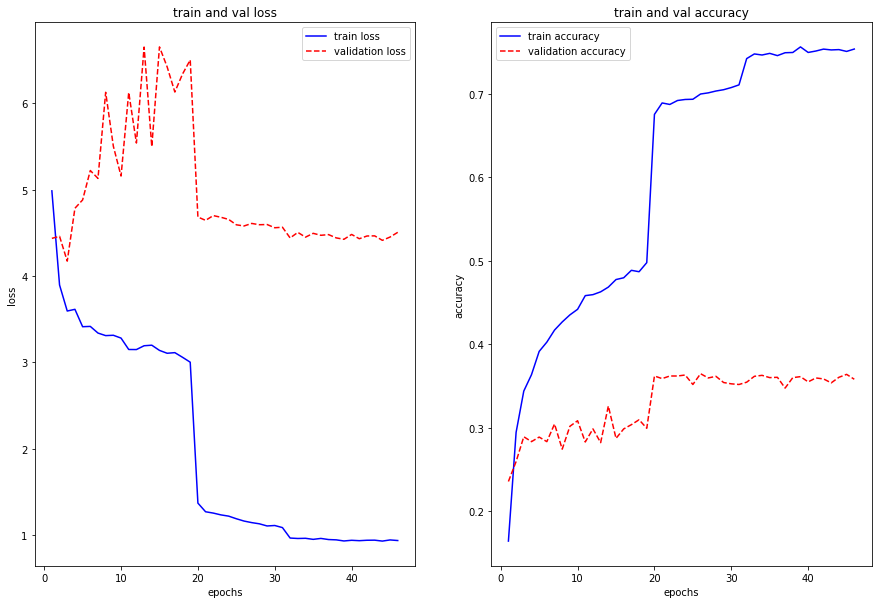

In [115]:



1


In [ ]:


model = model_generator(MobileNetV2,10,IMG_SIZE)
train_data,validation_data=image_preprocess(train_dir,IMG_SIZE)
model.summary()
model_name = "MobileNetV2"
model_learning(model,model_name,train_data,validation_data)


In [ ]:
model = model_generator(DenseNet121,10,IMG_SIZE)
train_data,validation_data=image_preprocess(train_dir,IMG_SIZE)
model.summary()
model_name = "DenseNet121"
model_learning(model,model_name,train_data,validation_data)

In [ ]:
model = model_generator(DenseNet201,10,IMG_SIZE)
train_data,validation_data=image_preprocess(train_dir,IMG_SIZE)
model.summary()
model_name = "DenseNet201"
model_learning(model,model_name,train_data,validation_data)

In [ ]:
model = model_generator(NASNetMobile,10,IMG_SIZE)
train_data,validation_data=image_preprocess(train_dir,IMG_SIZE)
model.summary()
model_name = "NASNetMobile"
model_learning(model,model_name,train_data,validation_data)

In [ ]:
model = model_generator(EfficientNetB0,10,IMG_SIZE)
train_data,validation_data=image_preprocess(train_dir,IMG_SIZE)
model.summary()
model_name = "EfficientNetB0"
model_learning(model,model_name,train_data,validation_data)

In [ ]:
model = model_generator(EfficientNetB1,10,IMG_SIZE)
train_data,validation_data=image_preprocess(train_dir,IMG_SIZE)
model.summary()
model_name = "EfficientNetB1"
model_learning(model,model_name,train_data,validation_data)

In [ ]:
model = model_generator(EfficientNetB2,10,IMG_SIZE)
train_data,validation_data=image_preprocess(train_dir,IMG_SIZE)
model.summary()
model_name = "EfficientNetB2"
model_learning(model,model_name,train_data,validation_data)

In [ ]:
model = model_generator(EfficientNetB3,10,IMG_SIZE)
train_data,validation_data=image_preprocess(train_dir,IMG_SIZE)
model.summary()
model_name = "EfficientNetB3"
model_learning(model,model_name,train_data,validation_data)

In [ ]:
model = model_generator(EfficientNetB4,10,IMG_SIZE)
train_data,validation_data=image_preprocess(train_dir,IMG_SIZE)
model.summary()
model_name = "EfficientNetB4"
model_learning(model,model_name,train_data,validation_data)

In [ ]:
model = model_generator(EfficientNetB5,10,IMG_SIZE)
train_data,validation_data=image_preprocess(train_dir,IMG_SIZE)
model.summary()
model_name = "EfficientNetB5"
model_learning(model,model_name,train_data,validation_data)

In [ ]:
model = model_generator(EfficientNetV2B0,10,IMG_SIZE)
train_data,validation_data=image_preprocess(train_dir,IMG_SIZE)
model.summary()
model_name = "EfficientNetV2B0"
model_learning(model,model_name,train_data,validation_data)

In [ ]:
model = model_generator(EfficientNetV2B1,10,IMG_SIZE)
train_data,validation_data=image_preprocess(train_dir,IMG_SIZE)
model.summary()
model_name = "EfficientNetV2B1"
model_learning(model,model_name,train_data,validation_data)

In [ ]:
model = model_generator(EfficientNetV2B2,10,IMG_SIZE)
train_data,validation_data=image_preprocess(train_dir,IMG_SIZE)
model.summary()
model_name = "EfficientNetV2B2"
model_learning(model,model_name,train_data,validation_data)

In [ ]:
model = model_generator(EfficientNetV2B3,10,IMG_SIZE)
train_data,validation_data=image_preprocess(train_dir,IMG_SIZE)
model.summary()
model_name = "EfficientNetV2B3"
model_learning(model,model_name,train_data,validation_data)

In [ ]:
model = model_generator(EfficientNetV2S,10,IMG_SIZE)
train_data,validation_data=image_preprocess(train_dir,IMG_SIZE)
model.summary()
model_name = "EfficientNetV2S"
model_learning(model,model_name,train_data,validation_data)

In [ ]:
model = model_generator(EfficientNetV2M,10,IMG_SIZE)
train_data,validation_data=image_preprocess(train_dir,IMG_SIZE)
model.summary()
model_name = "EfficientNetV2M"
model_learning(model,model_name,train_data,validation_data)

In [ ]:
model = model_generator(ResNet50V2,10,IMG_SIZE)
train_data,validation_data=image_preprocess(train_dir,IMG_SIZE)
model.summary()
model_name = "ResNet50V2"
model_learning(model,model_name,train_data,validation_data)

In [ ]:
model = model_generator(ResNet50,10,IMG_SIZE)
train_data,validation_data=image_preprocess(train_dir,IMG_SIZE)
model.summary()
model_name = "ResNet50"
model_learning(model,model_name,train_data,validation_data)

In [ ]:
model = model_generator(MobileNet,10,IMG_SIZE)
train_data,validation_data=image_preprocess(train_dir,IMG_SIZE)
model.summary()
model_name = "MobileNet"
model_learning(model,model_name,train_data,validation_data)

In [ ]:
model = model_generator(InceptionV3,10,IMG_SIZE)
train_data,validation_data=image_preprocess(train_dir,IMG_SIZE)
model.summary()
model_name = "InceptionV3"
model_learning(model,model_name,train_data,validation_data)